# Error Analysis - Multiple runs

This notebook provides a brief error analysis of 7 experiment results described in [our paper](https://github.com/omarkapur-mids/Exploring-Data-Augmentation-for-QA-with-T5/blob/main/ExploringDataAugmentation.pdf).

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import re
import os


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


t5_model = 't5-small'

In [3]:
e1 = pd.read_pickle("1__zeroshot_validation2146-Jul27.pkl")
e2 = pd.read_pickle("2__drop30_validation0632-Jul28.pkl")
e3 = pd.read_pickle("3__squad10-hotpot10-drop10_validation2104-Jul28.pkl")
e4 = pd.read_pickle("4__augmented-drop-5percent-30_validation0633-Jul29.pkl")
e5 = pd.read_pickle("5__augmented-drop-10percent-30_validation1657-Jul29.pkl")
e6 = pd.read_pickle("6__augmented-drop-25percent-30_validation0447-Jul30.pkl")
e7 = pd.read_pickle("7__augmented-drop-50percent-30_validation2219-Jul30.pkl")

In [4]:
def tag_questions(df):

    df.reset_index(drop=True, inplace = True) #clean up - adding indicies
    
    df['answer_type'] = df.answers_spans.apply(lambda d: d['types'][0])

    df['answers_list'] = df.answers_spans.apply(lambda z: z['spans'])


    df['EasyQ'] = df.apply(lambda z: 1 if len(set(z['passage'].split()).intersection(set(z.answers_list))) > 0 else 0,axis=1)
    df['MathEasyQ'] = np.where((df.EasyQ == 1) &(df.answer_type == 'number'),1,0)
    df['MathHardQ'] = np.where((df.answer_type == 'number')&(df.MathEasyQ == 0),1,0)

    df['Or'] = np.where(df.question.str.contains(" or ", flags=re.IGNORECASE), 1, 0)
    
    sort_keywords = ["est ","first","last","more","less","better","worse","larger","smaller"]
    sort_pat = '|'.join(sort_keywords)
    df['Sort'] = np.where(df.question.str.contains(sort_pat,flags=re.IGNORECASE), 1, 0)
    df['Sort'] = np.where(df.question.str.match(r'[^\s]+er\b', flags=re.IGNORECASE), 1, df.Sort)
   
    df['check_tot'] = df[['Or','Sort','MathEasyQ','MathHardQ']].sum(axis=1)
    
    df['Or_Sort'] = df.apply(lambda z: 1 if z[['Or','Sort']].sum() == 2 else 0,axis=1)
    df['Or_Easy'] = df.apply(lambda z: 1 if z[['Or','MathEasyQ']].sum() == 2 else 0,axis=1)
    df['Or_Hard'] = df.apply(lambda z: 1 if z[['Or','MathHardQ']].sum() == 2 else 0,axis=1)
    df['Sort_Easy'] = df.apply(lambda z: 1 if z[['Sort','MathEasyQ']].sum() == 2 else 0,axis=1)
    df['Sort_Hard'] = df.apply(lambda z: 1 if z[['Sort','MathHardQ']].sum() == 2 else 0,axis=1)
    df['Or_Sort_Easy'] = df.apply(lambda z: 1 if z[['Or','MathEasyQ', 'Sort']].sum() == 3 else 0,axis=1)
    df['Or_Sort_Hard'] = df.apply(lambda z: 1 if z[['Or','MathHardQ', 'Sort']].sum() == 3 else 0,axis=1)
    
    q_list = ['Or','Sort','MathEasyQ','MathHardQ', 'Or_Sort', 'Or_Easy', 'Or_Hard', 'Sort_Easy', 'Sort_Hard', 'Or_Sort_Easy', 'Or_Sort_Hard' ]
    a_list = ['span','number','date']
    
    metrics = []
    for q in q_list:
        l = []
        count = sum(df[q] == 1)
        l.append(count)
        f1 = df[df[q]==1].F1.mean()
        l.append(f1)
        em = df[df[q]==1].EM.mean()
        l.append(em)
        l.append(q)
        metrics.append(l)
    
    ans_metrics = []
    for a in a_list:
        l = []
        count = sum(df['answer_type'] == a)
        l.append(count)
        f1 = df[df['answer_type']==a].F1.mean()
        l.append(f1)
        em = df[df['answer_type']==a].EM.mean()
        l.append(em)
        l.append(a)
        ans_metrics.append(l)
    
    df2 = pd.DataFrame(np.array(metrics), columns=['Count', 'F1', 'EM', 'Q_Type'])
    df3 = pd.DataFrame(np.array(ans_metrics), columns=['Count', 'F1', 'EM', 'Ans_Type'])
    
    return df, df2, df3

In [61]:
drop_val[drop_val.MathEasyQ == 1].sample(3)

,section_id,query_id,passage,question,answers_spans,predicted,EM,F1,answer_type,answers_list,EasyQ,MathEasyQ,MathHardQ,Or,Sort,check_tot,Or_Sort,Or_Easy,Or_Hard,Sort_Easy,Sort_Hard,Or_Sort_Easy,Or_Sort_Hard,topic
7860,nfl_2036,39efba76-501b-43e4-b10d-e6d414cdba5d,"Coming off their home win over the Browns, th...",What was the longest field goal of the first q...,"{'spans': ['39', '39-yard'], 'types': ['number...",a23 -yard field goal,0.0,0.0,number,"[39, 39-yard]",1,1,0,0,1,2,0,0,0,1,0,0,0,nfl
9304,history_2961,83264b6c-2e83-4b9c-81d0-6c81c376d1bf,"In 2004 Philadelphia Eagles season, the Philad...",How many more wins did the Eagles have than lo...,"{'spans': ['10', '10'], 'types': ['number', 'n...",ten,0.0,0.0,number,"[10, 10]",1,1,0,0,1,2,0,0,0,1,0,0,0,history
266,nfl_1618,c1e75ff2-1459-4b58-9a5b-bbe49790456f,Hoping to rebound from their tough loss to th...,How many field goals did Nate Kaeding kick?,"{'spans': ['3', '3'], 'types': ['number', 'num...",25,0.0,0.0,number,"[3, 3]",1,1,0,0,0,1,0,0,0,0,0,0,0,nfl


In [62]:
print_example('83264b6c-2e83-4b9c-81d0-6c81c376d1bf',drop_val)

question:  How many more wins did the Eagles have than losses?
passage:  In 2004 Philadelphia Eagles season, the Philadelphia Eagles had their best season since 1960, going 13-1 before resting their starters and losing their next 2, clinching the number one seed for the second year in a row. McNabb set career highs, completing 64% of his passes for 3,875 yards, though he didnt play all 16 games. McNabb became the first quarterback ever to throw more than 30 touchdowns and fewer than 10 interceptions in a season. His success could be attributed to the fact that he had a reliable receiver, Terrell Owens, who got 1,200 yards and 14 touchdowns in 14 games. After defeating the Minnesota Vikings and Atlanta Falcons, the Eagles advanced to Super Bowl XXXIX, where they dueled the 2004 New England Patriots season. Although McNabb threw 3 touchdown passes and 357 yards in the game, and the score was tied 14-14 going into the fourth quarter, the Patriots outscored the Eagles and scored ten straig

In [59]:
print_example('edd1da63-f564-456c-8e53-f497b6302e4d',drop_val)

question:  How many field goals did the Cowboys make?
passage:   This game involved a scary moment, after Seattle's  Ricardo Lockette was hit during a kick return. He lied on the ground, motionless, for about 7 minutes before he was taken off the field on a cart. X-rays later revealed that Lockette had a broken neck. The injury ended his career. The Cowboys would only kick field goals in this game, as Dan Bailey was 4 for 4 on field goals. Dallas lead 12-10 with under 2 minutes to go. However, the Seahawks would march down the field and would take a 13-12 lead after Steven Hauschka drilled a 24-yard field goal. Dallas tried to come back, but Seattle forced a turnover on downs to end the game.

predicted answer:  4
True answers:  {'spans': array(['4', '4', '4'], dtype=object), 'types': array(['number', 'number', 'number'], dtype=object)}
F1 score:  1.0
EM score:  1.0


In [5]:
e1, e1_metrics, e1_ans_metrics = tag_questions(e1)
e2, e2_metrics, e2_ans_metrics = tag_questions(e2)
e3, e3_metrics, e3_ans_metrics = tag_questions(e3)
e4, e4_metrics, e4_ans_metrics = tag_questions(e4)
e5, e5_metrics, e5_ans_metrics = tag_questions(e5)
e6, e6_metrics, e6_ans_metrics = tag_questions(e6)
e7, e7_metrics, e7_ans_metrics = tag_questions(e7)

#### probe drop train and validation

In [52]:
drop_val = e1.copy()
drop_val['topic'] = drop_val.section_id.str.split('_',1).str[0]
#drop_val.topic.value_counts()

In [49]:
from datasets import Dataset, load_dataset
drop_train_dataset = load_dataset('drop',split='train')
drop_train = drop_train_dataset.to_pandas()

drop_train['answer_type'] = drop_train.answers_spans.apply(lambda d: d['types'][0])
drop_train['answers_list'] = drop_train.answers_spans.apply(lambda z: z['spans'])
drop_train['EasyQ'] = drop_train.apply(lambda z: 1 if len(set(z['passage'].split()).intersection(set(z.answers_list))) > 0 else 0,axis=1)

Using custom data configuration default
Reusing dataset drop (/home/omar/.cache/huggingface/datasets/drop/default/0.1.0/393cc04823935c1302a6a7e380cdbe9f452d37858ea276409787c983748eae25)


#### Easy questions == answer is in the context

##### DROP training data:

In [50]:
drop_train.EasyQ.value_counts(dropna=False)

0    64723
1    12677
Name: EasyQ, dtype: int64

In [53]:
drop_train.EasyQ.value_counts(dropna=False) / len(drop_train)

0    0.836214
1    0.163786
Name: EasyQ, dtype: float64

#### validation data:

In [51]:
drop_val.EasyQ.value_counts(dropna=False)

0    7710
1    1825
Name: EasyQ, dtype: int64

In [54]:
drop_val.EasyQ.value_counts(dropna=False) / len(drop_val)

0    0.8086
1    0.1914
Name: EasyQ, dtype: float64

#### Answer type breakdown

##### training data

In [40]:
drop_train.answer_type.value_counts(dropna=False)

number    46973
span      29195
date       1232
Name: answer_type, dtype: int64

In [41]:
drop_train.answer_type.value_counts(dropna=False) / len(drop_train)

number    0.606886
span      0.377196
date      0.015917
Name: answer_type, dtype: float64

#### validation data:

In [42]:
drop_val.answer_type.value_counts(dropna=False)

number    5889
span      3503
date       143
Name: answer_type, dtype: int64

In [43]:
drop_val.answer_type.value_counts(dropna=False) / len(drop_val)

number    0.617619
span      0.367383
date      0.014997
Name: answer_type, dtype: float64

#### Question topic breakdown

##### training data

In [75]:
drop_train['topic'] = drop_train.section_id.str.split('_',1).str[0]
drop_train.topic.value_counts()

nfl        41575
history    35825
Name: topic, dtype: int64

In [46]:
drop_train.topic.value_counts() / len(drop_train)

nfl        0.537145
history    0.462855
Name: topic, dtype: float64

##### validation data

In [45]:
drop_val.topic.value_counts() / len(drop_val)

history    0.706765
nfl        0.293235
Name: topic, dtype: float64

#### Question type breakdown

In [69]:
met = e1_metrics.copy()
met.Count = met.Count.astype('int')
met[['Q_Type','Count']].sort_values('Count',ascending=False).reset_index(drop=True)

,Q_Type,Count
0,MathHardQ,5528
1,Sort,3987
2,Sort_Hard,1807
3,Or,1805
4,Or_Sort,1322
5,MathEasyQ,361
6,Or_Hard,279
7,Sort_Easy,147
8,Or_Sort_Hard,100
9,Or_Easy,19


#### experiment results plots

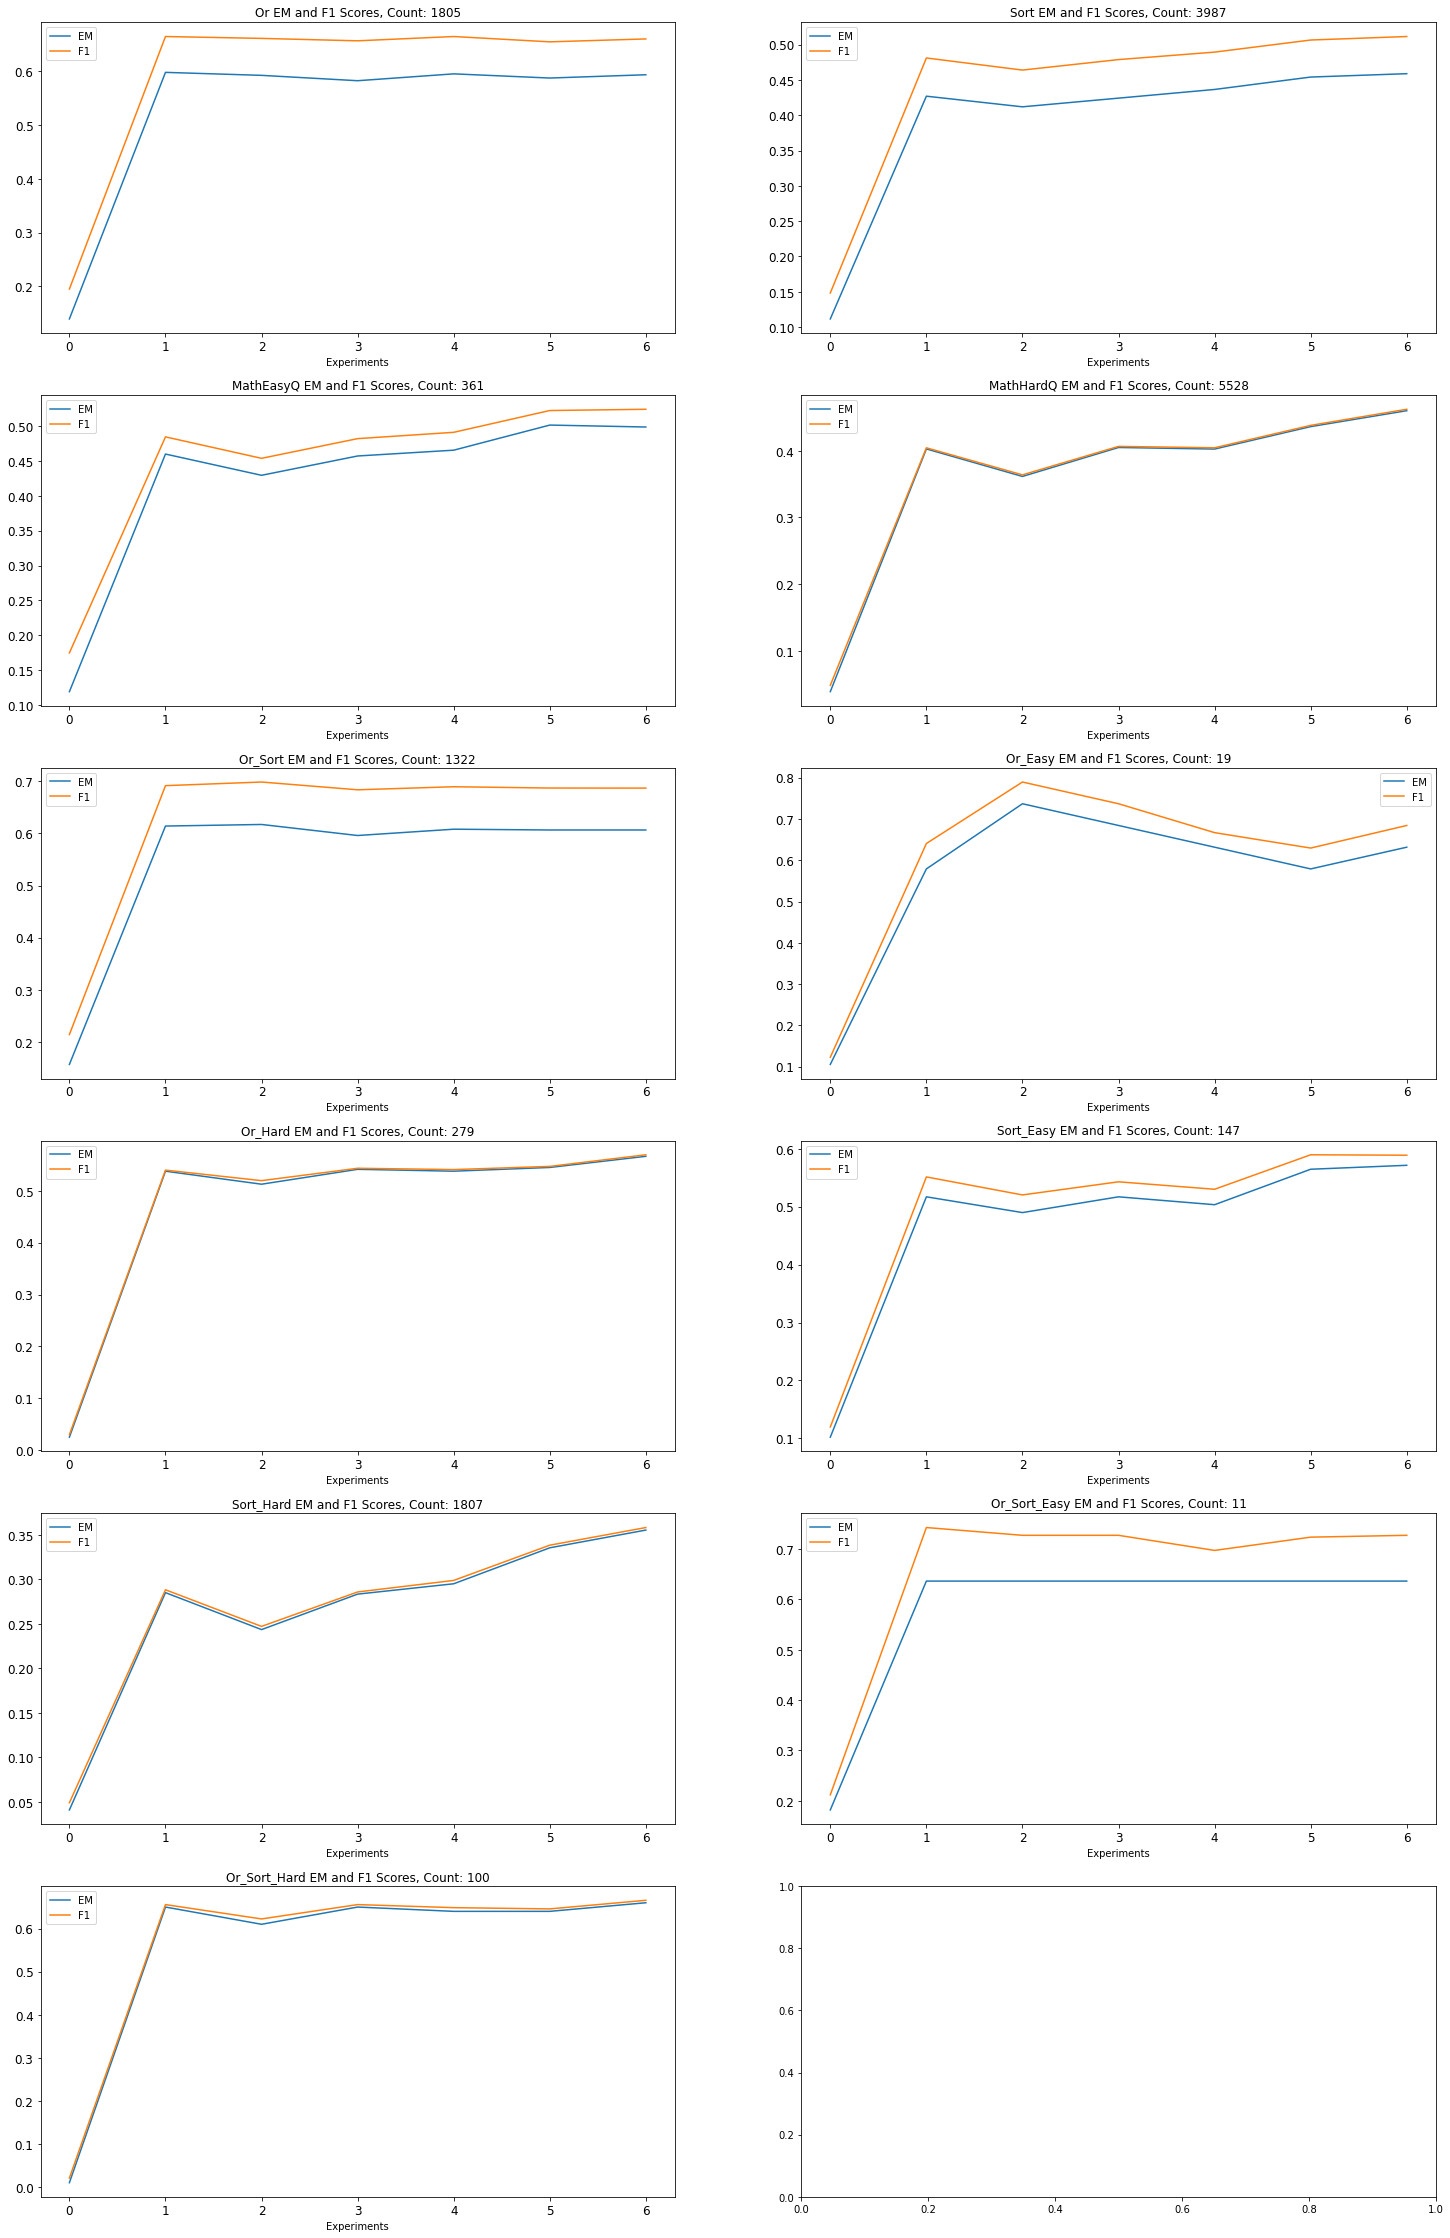

In [9]:
q_list = ['Or','Sort','MathEasyQ','MathHardQ', 'Or_Sort', 'Or_Easy', 'Or_Hard', 'Sort_Easy', 'Sort_Hard', 'Or_Sort_Easy', 'Or_Sort_Hard' ]

for q in q_list:
    globals()[f"{q}"] = pd.concat([e1_metrics[e1_metrics['Q_Type'] == q], e2_metrics[e2_metrics['Q_Type'] == q], 
                         e3_metrics[e3_metrics['Q_Type'] == q],e4_metrics[e4_metrics['Q_Type'] == q], 
                         e5_metrics[e5_metrics['Q_Type'] == q],e6_metrics[e6_metrics['Q_Type'] == q],e7_metrics[e7_metrics['Q_Type'] == q]], 
                         axis=0, ignore_index= 'TRUE')


fig, axes = plt.subplots(nrows=6, ncols=2, figsize = (25,40))

r=0
c=0
q_objects = [Or,Sort,MathEasyQ,MathHardQ, Or_Sort, Or_Easy, Or_Hard, Sort_Easy, Sort_Hard, Or_Sort_Easy, Or_Sort_Hard ]
for o in range(0,11): 
    df = q_objects[o][["EM", "F1"]]
    df=df.astype(float)
    t = q_list[o] + " EM and F1 Scores, Count: " + q_objects[o]["Count"][1]
    df.plot(title = t, ax=axes[r,c], xlabel = "Experiments", fontsize = 12, kind = "line")
    
    if o%2 == 0:  
        c = c + 1
    else:
        r = r + 1
        c = c - 1

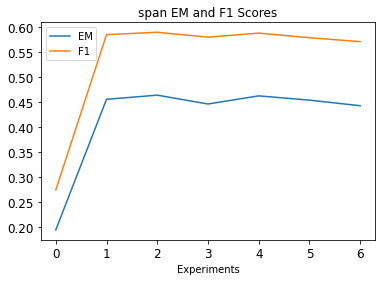

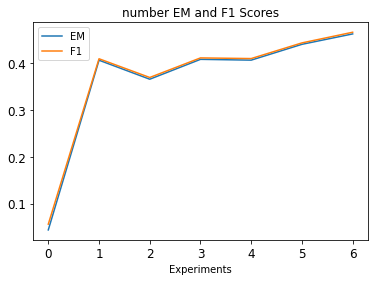

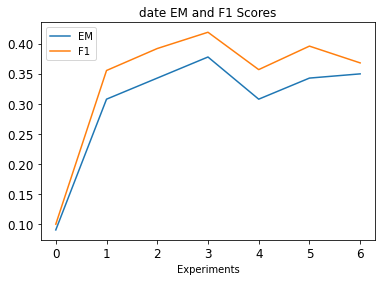

In [11]:
a_list = ['span','number','date']
for a in a_list:
    globals()[f"{a}_data"] = pd.concat([e1_ans_metrics[e1_ans_metrics['Ans_Type'] == a], e2_ans_metrics[e2_ans_metrics['Ans_Type'] == a], 
                                        e3_ans_metrics[e3_ans_metrics['Ans_Type'] == a],e4_ans_metrics[e4_ans_metrics['Ans_Type'] == a], 
                                        e5_ans_metrics[e5_ans_metrics['Ans_Type'] == a],e6_ans_metrics[e6_ans_metrics['Ans_Type'] == a],
                                        e7_ans_metrics[e7_ans_metrics['Ans_Type'] == a]], ignore_index= 'TRUE')

#fig, axes = plt.subplots(nrows=3, ncols=1, figsize = (25,40))

a_objects = [span_data, number_data, date_data]
for o in range(0,3): 
    df = a_objects[o][["EM", "F1"]]
    df = df.astype(float)
    t = a_list[o] + " EM and F1 Scores"
    df.plot(title = t, xlabel = "Experiments", fontsize = 12, kind = "line") 